## Final Project

In [283]:
# Data tools and graphing tools
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
# text tools
import nltk
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob 
nltk.download(["stopwords", "punkt", "wordnet"])
import string
import re

# model tools
import tensorflow as tf
from  tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import kerastuner as kt
from tensorflow import keras

# evaluation tools
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam_glass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [183]:
df = pd.read_csv("../project/Data/hate-text.csv")
df.head()

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


In [185]:
# removing case id from data frame
df =df.drop("case_id",axis=1)
df

,test_case,label_gold,target_ident
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people
...,...,...,...
3896,Gay people are all complete 4ssholes.,hateful,gay people
3897,Black people are all complete 4ssholes.,hateful,black people
3898,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,Muslims are all complete 4ssholes.,hateful,Muslims


In [186]:
# Checking to see if there are any nan entries within the data set
df.isnull().sum()

test_case         0
label_gold        0
target_ident    295
dtype: int64

In [187]:
nans = pd.isnull(df["target_ident"]) #selecting all nans
df[nans].to_csv("../project/Data/nans.csv") # saving as csv to closer inspect
df[nans]


,test_case,label_gold,target_ident
1271,"Fucking hell, what a day.",non-hateful,NaN
1272,That's a great fucking idea.,non-hateful,NaN
1273,No fucking way.,non-hateful,NaN
1274,I'm so fucking excited.,non-hateful,NaN
1275,Are you fucking kidding me?,non-hateful,NaN
...,...,...,...
3097,Pro lifers should get the fuck out of our coun...,non-hateful,NaN
3098,Most gun dealers are seriously fucked in the h...,non-hateful,NaN
3099,"By nature, corporate accountants are just shit...",non-hateful,NaN
3100,Most real estate agents are absolute bastards.,non-hateful,NaN


There is 295 entries in the target identity column that are nan numbers. These should either be removed or corrected. In this case I think I will remove them as when I closer inspected the data, it seemed that most of the comments were irrelevant. They gave a very unsure insight into what is non-hateful speech.

In [188]:
df = df.dropna() # dropping the nan values from the target column and the whole dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606 entries, 0 to 3900
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   test_case     3606 non-null   object
 1   label_gold    3606 non-null   object
 2   target_ident  3606 non-null   object
dtypes: object(3)
memory usage: 112.7+ KB


In [189]:
# Checking for duplicated entries
duplicates =df[df.duplicated]
print(f"Duplicates {duplicates}")

Duplicates Empty DataFrame
Columns: [test_case, label_gold, target_ident]
Index: []


Now the data set contains 3606 entries. I will now explore to see how the data is distributed over the different features.

In [190]:
group_data = df.groupby("label_gold").size().reset_index(name="counts")
group_data

,label_gold,counts
0,hateful,2659
1,non-hateful,947


In [191]:
category_data = df.groupby("target_ident").size().reset_index(name="counts")
category_data

,target_ident,counts
0,Muslims,510
1,black people,504
2,disabled people,510
3,gay people,577
4,immigrants,485
5,trans people,485
6,women,535


In [192]:
count_df = df.groupby(["label_gold", "target_ident"]).size() # grouping by the label_gold
count_df

label_gold   target_ident   
hateful      Muslims            388
             black people       369
             disabled people    388
             gay people         388
             immigrants         369
             trans people       369
             women              388
non-hateful  Muslims            122
             black people       135
             disabled people    122
             gay people         189
             immigrants         116
             trans people       116
             women              147
dtype: int64

<Axes: title={'center': 'Grouped_data'}, xlabel='label_gold,target_ident'>

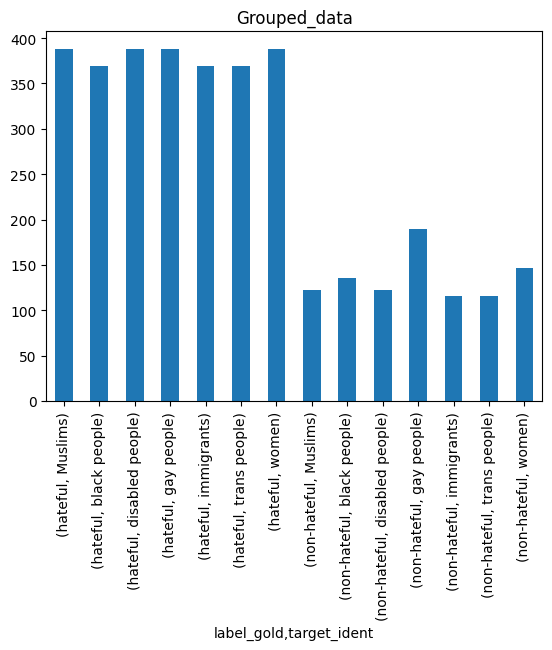

In [193]:
count_df.plot(
    x="label_gold",
    kind="bar",
    title="Grouped_data"
)

From the graph we can see that the data is rather balanced within the two categories hateful and non hateful. However as a whole there are more hateful statements then non hateful. This could have a bias on the model. It would be good if I were able to balance this within the model. 

## Data Processing

The next stage of the process is to clean the data and to prepare it for use within the model. I need to ensure that that everything is in lowercase, remove any number, any punctuation and any unnecessary whitespace. I will also fix any misspelled words 

In [194]:
spell_check_df = pd.DataFrame()
spell_check_df["test_case"] = df["test_case"]
spell_check_df["label_gold"] = df["label_gold"]
spell_check_df["target_ident"] = df["target_ident"]

spell_check_df["test_case"] = df["test_case"].apply(lambda x: ''.join(TextBlob(x).correct()))

In [195]:
spell_check_df.to_csv("../project/Data/spellcheck.csv", index=False)
spell_check_df

,test_case,label_gold,target_ident
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people
...,...,...,...
3896,May people are all complete 4ssholes.,hateful,gay people
3897,Black people are all complete 4ssholes.,hateful,black people
3898,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,Muslims are all complete 4ssholes.,hateful,Muslims


In [196]:
def clean_text(text):
    text = text.lower()
    # removing square brackets (will come in handy later) and punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # removing numbers from start or end of a word
    text = text.strip(string.digits)
    # removing numbers from within words
    text = re.sub(r'\b(\w*\d\w*)\b', lambda x: re.sub('\d', '', x.group()), text)
    # removing extra whitespace
    text = re.sub(' +', ' ',text)
    
    return text  

In [197]:
df["test_case"] = pd.DataFrame(df.test_case.apply(clean_text))

spell_check_df["test_case"] = pd.DataFrame(spell_check_df.test_case.apply(clean_text))

spell_check_df["test_case"] = pd.DataFrame(spell_check_df.test_case.apply(clean_text))

df, spell_check_df

/tmp/ipykernel_946/3717588590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["test_case"] = pd.DataFrame(df.test_case.apply(clean_text))


(                                      test_case label_gold     target_ident
 0                                 i hate women     hateful            women
 1                          i hate trans people     hateful     trans people
 2                            i hate gay people     hateful       gay people
 3                          i hate black people     hateful     black people
 4                       i hate disabled people     hateful  disabled people
 ...                                         ...        ...              ...
 3896       gay people are all complete ssholes     hateful       gay people
 3897     black people are all complete ssholes     hateful     black people
 3898  disabled people are all complete ssholes     hateful  disabled people
 3899          muslims are all complete ssholes     hateful          Muslims
 3900       immigrants are all complete ssholes     hateful       immigrants
 
 [3606 rows x 3 columns],
                                       test_case

In [198]:
def augment_with_emotion(row, aug):
    original_text = row["test_case"]
    original_label = row["label_gold"]
    original_emotion = row["target_ident"]

    
    augmented_text = aug.augment(original_text)
    
    # Create a new row with augmented text and the original emotion label
    row["test_case"] = augmented_text
    row["label_gold"] = original_label
    row["target_ident"] = original_emotion
    
    return row

# Augmenter configuration
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Apply the augmentation function to each row in the DataFrame
augmented_df = df_non_hateful.apply(lambda row: augment_with_emotion(row, aug), axis=1)

augmented_df['test_case'] = augmented_df["test_case"].apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", ''))

augmented_df.to_csv("../project/Data/augmented.csv", index=False)

NameError: name 'df_non_hateful' is not defined

In [ ]:
df_non_hateful_aug = pd.read_csv("../project/Data/augmented.csv")
df_non_hateful_aug

,test_case,label_gold,target_ident
0,2010 building new dyke near ocean beach,non-hateful,gay people
1,went onto walk behind dyke water,non-hateful,gay people
2,parish council had built gates two dyke protec...,non-hateful,gay people
3,dyked marshland located along river provide wi...,non-hateful,gay people
4,dyke long wall drains embankment once built pr...,non-hateful,gay people
...,...,...,...
942,writing gay people asshole magazines say what ...,non-hateful,gay people
943,in writing black people asshole say how lot up...,non-hateful,black people
944,writing disabled homeless people asshole would...,non-hateful,disabled people
945,but writing muslim asshole biography say of lo...,non-hateful,Muslims


I have augmented The non hateful text in the hope that it will make the data set more balanced. 
I will now split the data. 
When I split the data I will add the augmented data to the training data only.This is to ensure that the data is balanced for the model to train on. I will not add augmented data to the test data. The reason for this is because the augmented data only makes a small change on the original data to ensure it is different. So if I were to add it to the test data this could provide potential data leakage.   

#### Stop words and Lemmatizing

In [199]:
def preprocess_text(text):
    #Remove stop words

    stop_words = set(stopwords.words("english"))
    tokens = text.split() # splitting the words one by one
    filtered_tokens = [token for token in tokens if token not in stop_words] # keeping the words that are not stop words

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemmatized_tokens)

    return processed_text

In [200]:
df.loc[:, "test_case"] = df["test_case"].apply(preprocess_text)

spell_check_df.loc[:, "test_case"] = spell_check_df["test_case"].apply(preprocess_text)

df_non_hateful_aug.loc[:, "test_case"] = df_non_hateful_aug["test_case"].apply(preprocess_text)

df, spell_check_df,

NameError: name 'df_non_hateful_aug' is not defined

In [ ]:
df_non_hateful_aug

,test_case,label_gold,target_ident
0,2010 building new dyke near ocean beach,non-hateful,gay people
1,went onto walk behind dyke water,non-hateful,gay people
2,parish council built gate two dyke protect tow...,non-hateful,gay people
3,dyked marshland located along river provide wi...,non-hateful,gay people
4,dyke long wall drain embankment built prevent ...,non-hateful,gay people
...,...,...,...
942,writing gay people asshole magazine say lot sm...,non-hateful,gay people
943,writing black people asshole say lot small minded,non-hateful,black people
944,writing disabled homeless people asshole would...,non-hateful,disabled people
945,writing muslim asshole biography say lot small...,non-hateful,Muslims


I will now check the number of words there are in the datasets now. This is so I can get an idea on how big my total words and length of sentence should be for my model.

In [201]:
def num_words(data):

    strings_len = pd.Series(data["test_case"]).str.len()

    return strings_len.describe()

In [202]:
num_words(df)


count    3606.000000
mean       28.879368
std        10.627817
min         3.000000
25%        21.000000
50%        27.000000
75%        36.000000
max        65.000000
Name: test_case, dtype: float64

In [203]:
num_words(spell_check_df)

count    3606.000000
mean       28.774542
std        10.638502
min         0.000000
25%        21.000000
50%        27.000000
75%        35.000000
max        65.000000
Name: test_case, dtype: float64

#### Tokenize, padding and label encoding

In [204]:
#encoding the two label columns
def label_encoder(data):
    enc = LabelEncoder()

    data["label_gold"]= enc.fit_transform(data["label_gold"])
    data["target_ident"]= enc.fit_transform(data["target_ident"]) 
    
    return data.head()



In [205]:
label_encoder(df)

/tmp/ipykernel_946/2071669114.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label_gold"]= enc.fit_transform(data["label_gold"])
/tmp/ipykernel_946/2071669114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target_ident"]= enc.fit_transform(data["target_ident"])


,test_case,label_gold,target_ident
0,hate woman,0,6
1,hate trans people,0,5
2,hate gay people,0,3
3,hate black people,0,1
4,hate disabled people,0,2


In [206]:
label_encoder(spell_check_df)

,test_case,label_gold,target_ident
0,hate woman,0,6
1,hate trans people,0,5
2,hate gay people,0,3
3,hate black people,0,1
4,hate disabled people,0,2


#### Splitting data

In [207]:
# Splitting the data set
X_train, X_test = train_test_split(df, test_size=0.2, random_state= 42, stratify=df["target_ident"])
X_train, X_val = train_test_split(X_train, train_size=0.7, random_state=42,stratify=X_train["target_ident"])

separating the two outputs variables and creating an array to with them

In [208]:
def output_form(data):
    opinion = data.pop("label_gold")
    opinion = np.array(opinion)
    target_ident = data.pop("target_ident")
    target_ident = np.array(target_ident)

    return (opinion, target_ident)

In [209]:
y_train = output_form(X_train)
y_test = output_form(X_test)
y_val = output_form(X_val)

In [210]:
# converting X data to series as when tokenizing and padding it does not work with a a dataframe
X_train = X_train.squeeze()
X_val = X_val.squeeze()
X_test = X_test.squeeze()

In [211]:
X_train

2019                      cut disabled people throat
178                      black people like repugnant
1545    immigrant must committed crime violent cruel
155               trans people absolutely despicable
2743             call open hatred gay people society
                            ...                     
2846               really okay calling people jihadi
1626                    life worth shit black people
1894                    muslim deserve tortured like
2570     make say stuff like gay people disgust much
136                    absolutely abhor black people
Name: test_case, Length: 2018, dtype: object

In [212]:
# Tokenize the text data
def tokenizer_padding(X_train, X_val, X_test,max_words, max_length):
        
        tokenizer = Tokenizer(num_words=max_words) # setting max words
        tokenizer.fit_on_texts(X_train.astype(str)) # fitting tokenizer to fit/learn on the X train

        X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str)) # applying to the different X sequences
        X_val_seq = tokenizer.texts_to_sequences(X_val.astype(str))
        X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))


        vocab_size = len(tokenizer.word_index) + 1 #Printing length of the words in the tokenizer
        print(vocab_size)
        print(tokenizer.word_index) # printing the list of tokenized words

        for i in range (5):
            print(f"Sequence {i + 1}: {X_train_seq[i]}")


        max_sequence_length = max_length

        X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post") # adding padding to each set
        X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding="post")
        X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

        for i in range (3):
            print(f"Sequence{i +1}: {X_train_padded[i]}") # printing first 3 sequences in the X_train  

        return X_train_padded, X_val_padded, X_test_padded

In [213]:
X_train, X_val, X_test = tokenizer_padding(X_train, X_val, X_test, 3606, 40)

804
{'people': 1, 'like': 2, 'trans': 3, 'muslim': 4, 'disabled': 5, 'black': 6, 'immigrant': 7, 'gay': 8, 'woman': 9, 'person': 10, 'life': 11, 'nothing': 12, 'country': 13, 'would': 14, 'typical': 15, 'make': 16, 'worth': 17, 'never': 18, 'e': 19, 'get': 20, 'many': 21, 'absolutely': 22, 'much': 23, 'going': 24, 'really': 25, 'kind': 26, 'think': 27, 'believe': 28, 'must': 29, 'human': 30, 'deserve': 31, 'society': 32, 'see': 33, 'thing': 34, 'behaviour': 35, 'calling': 36, 'complete': 37, 'die': 38, 'stop': 39, 'ought': 40, 'hate': 41, 'nature': 42, 'u': 43, 'worthless': 44, 'let': 45, 'saying': 46, 'r': 47, 'help': 48, 'seriously': 49, 'common': 50, 'l': 51, 'c': 52, 'around': 53, 'want': 54, 'one': 55, 'fuck': 56, 'respect': 57, 'without': 58, 'disgusting': 59, 'suffer': 60, 'shit': 61, 'fag': 62, 'being': 63, 'write': 64, 'executed': 65, 'sick': 66, 'queer': 67, 'scum': 68, 'bitch': 69, 'g': 70, 'n': 71, 'government': 72, 'say': 73, 'call': 74, 'stupid': 75, 'rid': 76, 'cannot': 

In [214]:
X_train

array([[ 81,   5,   1, ...,   0,   0,   0],
       [  6,   1,   2, ...,   0,   0,   0],
       [  7,  29, 250, ...,   0,   0,   0],
       ...,
       [  4,  31, 448, ...,   0,   0,   0],
       [ 16,  73, 205, ...,   0,   0,   0],
       [ 22, 268,   6, ...,   0,   0,   0]], dtype=int32)

In [231]:
y_train

(array([0, 0, 0, ..., 1, 1, 0]), array([2, 1, 4, ..., 0, 3, 1]))

## Designing the model

In [215]:
hidden_nodes = int(2/3 * (40 * 6))
print(f"The number of hidden nodes is: {hidden_nodes}")

The number of hidden nodes is: 160


In [312]:
# creating a base model, This can be adapted further after training and testing

def base_model(inputs):
    x = Embedding(804, 64, input_length=40)(inputs)
    x = LSTM(10,return_sequences=True) (x)
    x = LSTM(10,return_sequences=False) (x)
    o = Dense(240, activation="relu") (x)
    t = Dense(240, activation="relu") (x)

    return x, o, t

In [313]:
def final_model(inputs):
    _, o, t = base_model(inputs)
    opinion = Dense(units="2",activation ="softmax", name= "opinion") (o)
    target_ident = Dense(units= "7", activation="softmax", name= "target_ident") (t)
    model = Model(inputs=inputs, outputs= [opinion, target_ident])

    return model
    

In [314]:
# creating early stopping and model checkpoint so best model will be saved and the training will be stopped if no progress
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

checkpoint_filepath = "../project/model_save"

model_checkpoint_target_ident = ModelCheckpoint(
    filepath=f"{checkpoint_filepath}_target_ident",
    monitor="val_target_ident_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

model_checkpoint_opinion = ModelCheckpoint(
    filepath=f"{checkpoint_filepath}_opinion",
    monitor="val_opinion_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)



In [315]:
inputs = Input(shape=(40,))


In [316]:
model = final_model(inputs)

In [317]:
model.compile(optimizer="adam",
              loss= {"opinion" : "sparse_categorical_crossentropy",
                     "target_ident" : "sparse_categorical_crossentropy"},
              metrics={"opinion" : "accuracy",
                       "target_ident" : "accuracy"},
     )

In [318]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 40)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 40, 64)               51456     ['input_11[0][0]']            
                                                                                                  
 lstm_23 (LSTM)              (None, 40, 10)               3000      ['embedding_14[0][0]']        
                                                                                                  
 lstm_24 (LSTM)              (None, 10)                   840       ['lstm_23[0][0]']             
                                                                                            

In [308]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [319]:

history = model.fit(X_train, y_train, 
                validation_data=(X_val,y_val), 
                epochs=50, 
                callbacks=[early_stopping, model_checkpoint_opinion,model_checkpoint_target_ident]) 


Epoch 1/50


64/64 [==============================] - ETA: 0s - loss: 2.5561 - opinion_loss: 0.6074 - target_ident_loss: 1.9486 - opinion_accuracy: 0.7250 - target_ident_accuracy: 0.1487
Epoch 1: val_opinion_accuracy improved from -inf to 0.74942, saving model to ../project/model_save_opinion
INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets


INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 1: val_target_ident_accuracy improved from -inf to 0.15935, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 43s 551ms/step - loss: 2.5561 - opinion_loss: 0.6074 - target_ident_loss: 1.9486 - opinion_accuracy: 0.7250 - target_ident_accuracy: 0.1487 - val_loss: 2.5105 - val_opinion_loss: 0.5650 - val_target_ident_loss: 1.9454 - val_opinion_accuracy: 0.7494 - val_target_ident_accuracy: 0.1594
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 2.5270 - opinion_loss: 0.5798 - target_ident_loss: 1.9472 - opinion_accuracy: 0.7339 - target_ident_accuracy: 0.1601
Epoch 2: val_opinion_accuracy did not improve from 0.74942

Epoch 2: val_target_ident_accuracy did not improve from 0.15935
64/64 [==============================] - 6s 97ms/step - loss: 2.5270 - opinion_loss: 0.5798 - target_ident_loss: 1.9472 - opinion_accuracy: 0.7339 - target_ident_accuracy: 0.1601 - val_loss: 2.5069 - val_opinion_loss: 0.5626 - val_target_ident_loss: 1.9444 - val_opinion_accuracy: 0.7494 - val_target_ident_accuracy: 0.1594
Epoch 3/50
64/64 [=======================

INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 4: val_target_ident_accuracy improved from 0.15935 to 0.19977, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 28s 441ms/step - loss: 2.3068 - opinion_loss: 0.3804 - target_ident_loss: 1.9264 - opinion_accuracy: 0.8325 - target_ident_accuracy: 0.1799 - val_loss: 2.2528 - val_opinion_loss: 0.3362 - val_target_ident_loss: 1.9166 - val_opinion_accuracy: 0.8245 - val_target_ident_accuracy: 0.1998
Epoch 5/50
64/64 [==============================] - ETA: 0s - loss: 2.0705 - opinion_loss: 0.1758 - target_ident_loss: 1.8947 - opinion_accuracy: 0.9390 - target_ident_accuracy: 0.2052
Epoch 5: val_opinion_accuracy improved from 0.82448 to 0.93880, saving model to ../project/model_save_opinion
INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets


INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 5: val_target_ident_accuracy improved from 0.19977 to 0.21594, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 29s 452ms/step - loss: 2.0705 - opinion_loss: 0.1758 - target_ident_loss: 1.8947 - opinion_accuracy: 0.9390 - target_ident_accuracy: 0.2052 - val_loss: 2.0487 - val_opinion_loss: 0.1535 - val_target_ident_loss: 1.8952 - val_opinion_accuracy: 0.9388 - val_target_ident_accuracy: 0.2159
Epoch 6/50
64/64 [==============================] - ETA: 0s - loss: 1.9124 - opinion_loss: 0.1221 - target_ident_loss: 1.7903 - opinion_accuracy: 0.9623 - target_ident_accuracy: 0.2468
Epoch 6: val_opinion_accuracy improved from 0.93880 to 0.95612, saving model to ../project/model_save_opinion
INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets


INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 6: val_target_ident_accuracy improved from 0.21594 to 0.23672, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 26s 415ms/step - loss: 1.9124 - opinion_loss: 0.1221 - target_ident_loss: 1.7903 - opinion_accuracy: 0.9623 - target_ident_accuracy: 0.2468 - val_loss: 1.9138 - val_opinion_loss: 0.1466 - val_target_ident_loss: 1.7671 - val_opinion_accuracy: 0.9561 - val_target_ident_accuracy: 0.2367
Epoch 7/50
64/64 [==============================] - ETA: 0s - loss: 1.6758 - opinion_loss: 0.0905 - target_ident_loss: 1.5854 - opinion_accuracy: 0.9787 - target_ident_accuracy: 0.3067
Epoch 7: val_opinion_accuracy improved from 0.95612 to 0.97113, saving model to ../project/model_save_opinion
INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets


INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 7: val_target_ident_accuracy improved from 0.23672 to 0.29330, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 27s 433ms/step - loss: 1.6758 - opinion_loss: 0.0905 - target_ident_loss: 1.5854 - opinion_accuracy: 0.9787 - target_ident_accuracy: 0.3067 - val_loss: 1.7531 - val_opinion_loss: 0.1052 - val_target_ident_loss: 1.6479 - val_opinion_accuracy: 0.9711 - val_target_ident_accuracy: 0.2933
Epoch 8/50
64/64 [==============================] - ETA: 0s - loss: 1.5846 - opinion_loss: 0.0943 - target_ident_loss: 1.4903 - opinion_accuracy: 0.9722 - target_ident_accuracy: 0.3256
Epoch 8: val_opinion_accuracy improved from 0.97113 to 0.97229, saving model to ../project/model_save_opinion
INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets


INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 8: val_target_ident_accuracy improved from 0.29330 to 0.32333, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 26s 404ms/step - loss: 1.5846 - opinion_loss: 0.0943 - target_ident_loss: 1.4903 - opinion_accuracy: 0.9722 - target_ident_accuracy: 0.3256 - val_loss: 1.6442 - val_opinion_loss: 0.1106 - val_target_ident_loss: 1.5337 - val_opinion_accuracy: 0.9723 - val_target_ident_accuracy: 0.3233
Epoch 9/50
64/64 [==============================] - ETA: 0s - loss: 1.6313 - opinion_loss: 0.1097 - target_ident_loss: 1.5216 - opinion_accuracy: 0.9703 - target_ident_accuracy: 0.3196
Epoch 9: val_opinion_accuracy did not improve from 0.97229

Epoch 9: val_target_ident_accuracy did not improve from 0.32333
64/64 [==============================] - 5s 85ms/step - loss: 1.6313 - opinion_loss: 0.1097 - target_ident_loss: 1.5216 - opinion_accuracy: 0.9703 - target_ident_accuracy: 0.3196 - val_loss: 1.6878 - val_opinion_loss: 0.1248 - val_target_ident_loss: 1.5630 - val_opinion_accuracy: 0.9665 - val_target_ident_accuracy: 0.2818
Epoch 10/50
64/64 [======================

INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 18s 285ms/step - loss: 1.4913 - opinion_loss: 0.0750 - target_ident_loss: 1.4163 - opinion_accuracy: 0.9777 - target_ident_accuracy: 0.3578 - val_loss: 1.5798 - val_opinion_loss: 0.0862 - val_target_ident_loss: 1.4936 - val_opinion_accuracy: 0.9700 - val_target_ident_accuracy: 0.3360
Epoch 11/50
64/64 [==============================] - ETA: 0s - loss: 1.4788 - opinion_loss: 0.0663 - target_ident_loss: 1.4124 - opinion_accuracy: 0.9787 - target_ident_accuracy: 0.3697
Epoch 11: val_opinion_accuracy improved from 0.97229 to 0.97806, saving model to ../project/model_save_opinion
INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets


INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 11: val_target_ident_accuracy did not improve from 0.33603
64/64 [==============================] - 15s 244ms/step - loss: 1.4788 - opinion_loss: 0.0663 - target_ident_loss: 1.4124 - opinion_accuracy: 0.9787 - target_ident_accuracy: 0.3697 - val_loss: 1.5530 - val_opinion_loss: 0.0707 - val_target_ident_loss: 1.4823 - val_opinion_accuracy: 0.9781 - val_target_ident_accuracy: 0.3337
Epoch 12/50
64/64 [==============================] - ETA: 0s - loss: 1.4066 - opinion_loss: 0.0578 - target_ident_loss: 1.3489 - opinion_accuracy: 0.9846 - target_ident_accuracy: 0.3796
Epoch 12: val_opinion_accuracy did not improve from 0.97806

Epoch 12: val_target_ident_accuracy did not improve from 0.33603
64/64 [==============================] - 6s 87ms/step - loss: 1.4066 - opinion_loss: 0.0578 - target_ident_loss: 1.3489 - opinion_accuracy: 0.9846 - target_ident_accuracy: 0.3796 - val_loss: 1.6023 - val_opinion_loss: 0.1163 - val_target_ident_loss: 1.4860 - val_opinion_accuracy: 0.9642 - val_ta

INFO:tensorflow:Assets written to: ../project/model_save_opinion/assets



Epoch 13: val_target_ident_accuracy improved from 0.33603 to 0.34988, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 25s 397ms/step - loss: 1.3815 - opinion_loss: 0.0720 - target_ident_loss: 1.3096 - opinion_accuracy: 0.9777 - target_ident_accuracy: 0.3954 - val_loss: 1.5504 - val_opinion_loss: 0.1027 - val_target_ident_loss: 1.4477 - val_opinion_accuracy: 0.9792 - val_target_ident_accuracy: 0.3499
Epoch 14/50
64/64 [==============================] - ETA: 0s - loss: 1.3891 - opinion_loss: 0.0711 - target_ident_loss: 1.3180 - opinion_accuracy: 0.9851 - target_ident_accuracy: 0.4103
Epoch 14: val_opinion_accuracy did not improve from 0.97921

Epoch 14: val_target_ident_accuracy improved from 0.34988 to 0.38222, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 17s 261ms/step - loss: 1.3891 - opinion_loss: 0.0711 - target_ident_loss: 1.3180 - opinion_accuracy: 0.9851 - target_ident_accuracy: 0.4103 - val_loss: 1.5374 - val_opinion_loss: 0.1222 - val_target_ident_loss: 1.4153 - val_opinion_accuracy: 0.9654 - val_target_ident_accuracy: 0.3822
Epoch 15/50
64/64 [==============================] - ETA: 0s - loss: 1.3759 - opinion_loss: 0.0660 - target_ident_loss: 1.3099 - opinion_accuracy: 0.9817 - target_ident_accuracy: 0.4272
Epoch 15: val_opinion_accuracy did not improve from 0.97921

Epoch 15: val_target_ident_accuracy improved from 0.38222 to 0.40993, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 229ms/step - loss: 1.3759 - opinion_loss: 0.0660 - target_ident_loss: 1.3099 - opinion_accuracy: 0.9817 - target_ident_accuracy: 0.4272 - val_loss: 1.5449 - val_opinion_loss: 0.1136 - val_target_ident_loss: 1.4313 - val_opinion_accuracy: 0.9630 - val_target_ident_accuracy: 0.4099
Epoch 16/50
64/64 [==============================] - ETA: 0s - loss: 1.2840 - opinion_loss: 0.0598 - target_ident_loss: 1.2242 - opinion_accuracy: 0.9846 - target_ident_accuracy: 0.5040
Epoch 16: val_opinion_accuracy did not improve from 0.97921

Epoch 16: val_target_ident_accuracy improved from 0.40993 to 0.47691, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 241ms/step - loss: 1.2840 - opinion_loss: 0.0598 - target_ident_loss: 1.2242 - opinion_accuracy: 0.9846 - target_ident_accuracy: 0.5040 - val_loss: 1.3582 - val_opinion_loss: 0.0916 - val_target_ident_loss: 1.2666 - val_opinion_accuracy: 0.9746 - val_target_ident_accuracy: 0.4769
Epoch 17/50
64/64 [==============================] - ETA: 0s - loss: 1.1454 - opinion_loss: 0.0485 - target_ident_loss: 1.0969 - opinion_accuracy: 0.9896 - target_ident_accuracy: 0.5391
Epoch 17: val_opinion_accuracy did not improve from 0.97921

Epoch 17: val_target_ident_accuracy improved from 0.47691 to 0.50115, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 231ms/step - loss: 1.1454 - opinion_loss: 0.0485 - target_ident_loss: 1.0969 - opinion_accuracy: 0.9896 - target_ident_accuracy: 0.5391 - val_loss: 1.3155 - val_opinion_loss: 0.0997 - val_target_ident_loss: 1.2158 - val_opinion_accuracy: 0.9769 - val_target_ident_accuracy: 0.5012
Epoch 18/50
64/64 [==============================] - ETA: 0s - loss: 1.0718 - opinion_loss: 0.0478 - target_ident_loss: 1.0241 - opinion_accuracy: 0.9901 - target_ident_accuracy: 0.5679
Epoch 18: val_opinion_accuracy did not improve from 0.97921

Epoch 18: val_target_ident_accuracy improved from 0.50115 to 0.52309, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 16s 254ms/step - loss: 1.0718 - opinion_loss: 0.0478 - target_ident_loss: 1.0241 - opinion_accuracy: 0.9901 - target_ident_accuracy: 0.5679 - val_loss: 1.2941 - val_opinion_loss: 0.1023 - val_target_ident_loss: 1.1917 - val_opinion_accuracy: 0.9688 - val_target_ident_accuracy: 0.5231
Epoch 19/50
64/64 [==============================] - ETA: 0s - loss: 1.0389 - opinion_loss: 0.0507 - target_ident_loss: 0.9882 - opinion_accuracy: 0.9881 - target_ident_accuracy: 0.5808
Epoch 19: val_opinion_accuracy did not improve from 0.97921

Epoch 19: val_target_ident_accuracy did not improve from 0.52309
64/64 [==============================] - 5s 74ms/step - loss: 1.0389 - opinion_loss: 0.0507 - target_ident_loss: 0.9882 - opinion_accuracy: 0.9881 - target_ident_accuracy: 0.5808 - val_loss: 1.3465 - val_opinion_loss: 0.0937 - val_target_ident_loss: 1.2528 - val_opinion_accuracy: 0.9758 - val_target_ident_accuracy: 0.5173
Epoch 20/50
64/64 [===================

INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 230ms/step - loss: 0.9672 - opinion_loss: 0.0515 - target_ident_loss: 0.9157 - opinion_accuracy: 0.9881 - target_ident_accuracy: 0.6313 - val_loss: 1.3033 - val_opinion_loss: 0.1076 - val_target_ident_loss: 1.1957 - val_opinion_accuracy: 0.9711 - val_target_ident_accuracy: 0.5381
Epoch 22/50
64/64 [==============================] - ETA: 0s - loss: 0.9625 - opinion_loss: 0.0610 - target_ident_loss: 0.9015 - opinion_accuracy: 0.9836 - target_ident_accuracy: 0.6323
Epoch 22: val_opinion_accuracy did not improve from 0.97921

Epoch 22: val_target_ident_accuracy improved from 0.53811 to 0.57968, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 238ms/step - loss: 0.9625 - opinion_loss: 0.0610 - target_ident_loss: 0.9015 - opinion_accuracy: 0.9836 - target_ident_accuracy: 0.6323 - val_loss: 1.2400 - val_opinion_loss: 0.1125 - val_target_ident_loss: 1.1275 - val_opinion_accuracy: 0.9734 - val_target_ident_accuracy: 0.5797
Epoch 23/50
64/64 [==============================] - ETA: 0s - loss: 0.9347 - opinion_loss: 0.0480 - target_ident_loss: 0.8867 - opinion_accuracy: 0.9891 - target_ident_accuracy: 0.6283
Epoch 23: val_opinion_accuracy did not improve from 0.97921

Epoch 23: val_target_ident_accuracy did not improve from 0.57968
64/64 [==============================] - 5s 84ms/step - loss: 0.9347 - opinion_loss: 0.0480 - target_ident_loss: 0.8867 - opinion_accuracy: 0.9891 - target_ident_accuracy: 0.6283 - val_loss: 1.2454 - val_opinion_loss: 0.0991 - val_target_ident_loss: 1.1463 - val_opinion_accuracy: 0.9746 - val_target_ident_accuracy: 0.5647
Epoch 24/50
64/64 [===================

INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 19s 296ms/step - loss: 0.9237 - opinion_loss: 0.0478 - target_ident_loss: 0.8759 - opinion_accuracy: 0.9901 - target_ident_accuracy: 0.6368 - val_loss: 1.1866 - val_opinion_loss: 0.0908 - val_target_ident_loss: 1.0958 - val_opinion_accuracy: 0.9769 - val_target_ident_accuracy: 0.5935
Epoch 25/50
64/64 [==============================] - ETA: 0s - loss: 0.8891 - opinion_loss: 0.0437 - target_ident_loss: 0.8454 - opinion_accuracy: 0.9891 - target_ident_accuracy: 0.6511
Epoch 25: val_opinion_accuracy did not improve from 0.97921

Epoch 25: val_target_ident_accuracy did not improve from 0.59353
64/64 [==============================] - 5s 77ms/step - loss: 0.8891 - opinion_loss: 0.0437 - target_ident_loss: 0.8454 - opinion_accuracy: 0.9891 - target_ident_accuracy: 0.6511 - val_loss: 1.1715 - val_opinion_loss: 0.0821 - val_target_ident_loss: 1.0894 - val_opinion_accuracy: 0.9781 - val_target_ident_accuracy: 0.5843
Epoch 26/50
64/64 [===================

INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 243ms/step - loss: 0.8706 - opinion_loss: 0.0536 - target_ident_loss: 0.8170 - opinion_accuracy: 0.9871 - target_ident_accuracy: 0.6630 - val_loss: 1.1800 - val_opinion_loss: 0.0998 - val_target_ident_loss: 1.0802 - val_opinion_accuracy: 0.9758 - val_target_ident_accuracy: 0.5982
Epoch 29/50
64/64 [==============================] - ETA: 0s - loss: 0.8281 - opinion_loss: 0.0522 - target_ident_loss: 0.7759 - opinion_accuracy: 0.9881 - target_ident_accuracy: 0.6799
Epoch 29: val_opinion_accuracy did not improve from 0.97921

Epoch 29: val_target_ident_accuracy improved from 0.59815 to 0.59931, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 15s 229ms/step - loss: 0.8281 - opinion_loss: 0.0522 - target_ident_loss: 0.7759 - opinion_accuracy: 0.9881 - target_ident_accuracy: 0.6799 - val_loss: 1.2092 - val_opinion_loss: 0.0955 - val_target_ident_loss: 1.1137 - val_opinion_accuracy: 0.9711 - val_target_ident_accuracy: 0.5993
Epoch 30/50
64/64 [==============================] - ETA: 0s - loss: 0.8327 - opinion_loss: 0.0473 - target_ident_loss: 0.7854 - opinion_accuracy: 0.9886 - target_ident_accuracy: 0.6938
Epoch 30: val_opinion_accuracy did not improve from 0.97921

Epoch 30: val_target_ident_accuracy improved from 0.59931 to 0.64088, saving model to ../project/model_save_target_ident
INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


INFO:tensorflow:Assets written to: ../project/model_save_target_ident/assets


64/64 [==============================] - 14s 227ms/step - loss: 0.8327 - opinion_loss: 0.0473 - target_ident_loss: 0.7854 - opinion_accuracy: 0.9886 - target_ident_accuracy: 0.6938 - val_loss: 1.2386 - val_opinion_loss: 0.0911 - val_target_ident_loss: 1.1475 - val_opinion_accuracy: 0.9723 - val_target_ident_accuracy: 0.6409
Epoch 30: early stopping


In [289]:
loss, opinion_loss, target_ident_loss, opinion_accuracy, target_ident_accuracy = model.evaluate(x=X_val, y=y_val)
print(f'loss: {loss}')
print(f'opinion_loss: {opinion_loss}')
print(f'target_ident_loss: {target_ident_loss}')
print(f'opinon_accuracy: {opinion_accuracy}')
print(f'target_ident_accuracy: {target_ident_accuracy}')


28/28 [==============================] - 1s 24ms/step - loss: 2.6411 - opinion_loss: 0.6950 - target_ident_loss: 1.9462 - opinion_accuracy: 0.2506 - target_ident_accuracy: 0.1397
loss: 2.6411333084106445
opinion_loss: 0.6949802041053772
target_ident_loss: 1.9461530447006226
opinon_accuracy: 0.2505773603916168
target_ident_accuracy: 0.13972286880016327


In [247]:
#visualizing training and validation results 
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history["target_ident_accuracy"], label="Training Accuracy")
plt.plot(history.history["val_target_ident_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["target_ident_loss"], label="Hateful/Non-Hateful Training Loss")
plt.plot(history.history["val_target_ident_loss"], label="Hateful/Non-Hateful Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()opinion_accuracy

plt.subplot(2, 2, 1)
plt.plot(history.history["opinion_accuracy"], label=" Accuracy")
plt.plot(history.history["val_opinion_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history["val_opinion_loss"], label="Hateful/Non-Hateful Validation Loss")
plt.plot(history.history["val_opinion_loss"], label="Validation Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
print(model.summary())

best_model = load_model(checkpoint_filepath)

TypeError: Model.fit() got multiple values for argument 'batch_size'